# VAE-CF (holdout 20% users)
## This notebook uses the dataset split approach which ratings of 20% users holdout as test set.
If a warning "FutureWarning: Passing (type, 1)or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'." happens, it is caused by the newer version of numpy which is not consistant with tensorflow. This error can be ignored and will not affect the excution.

In [2]:
import os
import shutil
import sys
import numpy as np
from scipy import sparse
import pandas as pd
import scipy.stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
sn.set()

import tensorflow as tf
from tensorflow.contrib.layers import apply_regularization, l2_regularizer
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import bottleneck as bn
import time
from support_func import *
from evaluation_func import *
from VAE_CF import MultiVAE

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [3]:
DATA_DIR = '../raw_data/ml-1m/'

In [5]:
raw_data = pd.read_csv(os.path.join(DATA_DIR, 'ratings.csv'), header=0)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   userId     1000209 non-null  int64
 1   movieId    1000209 non-null  int64
 2   rating     1000209 non-null  int64
 3   timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


### Data splitting procedure

- Select 10K users as heldout users, 10K users as validation users, and the rest of the users for training
- Use all the items from the training users as item set
- For each of both validation and test user, subsample 80% as fold-in data and the rest for prediction 

In [6]:
def get_count(tp, id):
    playcount_groupbyid = tp[[id]].groupby(id, as_index=True)# 这里as index改成了true
    count = playcount_groupbyid.size()
    return count

In [7]:
def filter_triplets(tp, min_uc=5, min_sc=0):
    # Only keep the triplets for items which were clicked on by at least min_sc users. 
    if min_sc > 0:
        # find the number of times of occurance of each movie id：
        # itemcount contains movie ids and corresponding counts
        itemcount = get_count(tp, 'movieId')
        # select ratings of movies which occure more than min_sc times
        tp = tp[tp['movieId'].isin(itemcount.index[itemcount >= min_sc])]
    
    # Only keep the triplets for users who clicked on at least min_uc items
    # After doing this, some of the items will have less than min_uc users, but should only be a small proportion
    if min_uc > 0:
        usercount = get_count(tp, 'userId')
        # select ratings of users who has rated more than min_uc items
        tp = tp[tp['userId'].isin(usercount.index[usercount >= min_uc])]
    
    # Update both usercount and itemcount after filtering
    usercount, itemcount = get_count(tp, 'userId'), get_count(tp, 'movieId') 
    return tp, usercount, itemcount

Only keep items that are clicked on by at least 5 users

In [8]:
raw_data, user_activity, item_popularity = filter_triplets(raw_data)

In [9]:
sparsity = 1. * raw_data.shape[0] / (user_activity.shape[0] * item_popularity.shape[0])
print("After filtering, there are %d watching events from %d users and %d movies (sparsity: %.3f%%)" % 
      (raw_data.shape[0], user_activity.shape[0], item_popularity.shape[0], sparsity * 100))

After filtering, there are 1000209 watching events from 6040 users and 3706 movies (sparsity: 4.468%)


In [10]:
unique_uid = user_activity.index

np.random.seed(98765)
idx_perm = np.random.permutation(unique_uid.size)
unique_uid = unique_uid[idx_perm]

Split all users into three set in proportion of {trainining set: 60% users, validation set: 20% users, test set: 20% users}

In [11]:
# create train/validation/test users
n_users = unique_uid.size
n_heldout_users = int(user_activity.shape[0]/5)

tr_users = unique_uid[:(n_users - n_heldout_users * 2)]
vd_users = unique_uid[(n_users - n_heldout_users * 2): (n_users - n_heldout_users)]
te_users = unique_uid[(n_users - n_heldout_users):]
print("Training set has {0} users\nValidation set has {1} users\nTest set has {2} users".format(len(tr_users),len(vd_users),len(te_users)))

Training set has 3624 users
Validation set has 1208 users
Test set has 1208 users


In [12]:
train_plays = raw_data.loc[raw_data['userId'].isin(tr_users)]

In [13]:
unique_sid = pd.unique(train_plays['movieId']) 

In [14]:
# show2id： {sid: i}
# sid is movieId, i is the index of this movieId in unique_sid
show2id = dict((sid, i) for (i, sid) in enumerate(unique_sid)) 
# profile2id： {pid: i}
# pid is userId, i is the index of this userId in unique_uid
profile2id = dict((pid, i) for (i, pid) in enumerate(unique_uid)) 

In [15]:
# create path to store the processed data
pro_dir = os.path.join('holdout_user', 'pro_sg')

if not os.path.exists(pro_dir):
    os.makedirs(pro_dir)

with open(os.path.join(pro_dir, 'unique_sid.txt'), 'w') as f:
    for sid in unique_sid:
        f.write('%s\n' % sid)

In [16]:
def split_train_test_proportion(data, test_prop=0.2):
    data_grouped_by_user = data.groupby('userId')
    tr_list, te_list = list(), list()

    np.random.seed(98765)

    for i, (_, group) in enumerate(data_grouped_by_user):
        n_items_u = len(group)

        if n_items_u >= 5:
            idx = np.zeros(n_items_u, dtype='bool')
            idx[np.random.choice(n_items_u, size=int(test_prop * n_items_u), replace=False).astype('int64')] = True

            tr_list.append(group[np.logical_not(idx)])
            te_list.append(group[idx])
        else:
            tr_list.append(group)

        if i % 1000 == 0:
            print("%d users sampled" % i)
            sys.stdout.flush()

    data_tr = pd.concat(tr_list)
    data_te = pd.concat(te_list)
    
    return data_tr, data_te

In [17]:
vad_plays = raw_data.loc[raw_data['userId'].isin(vd_users)]
vad_plays = vad_plays.loc[vad_plays['movieId'].isin(unique_sid)]

In [18]:
vad_plays_tr, vad_plays_te = split_train_test_proportion(vad_plays)

0 users sampled
1000 users sampled


In [19]:
test_plays = raw_data.loc[raw_data['userId'].isin(te_users)]
test_plays = test_plays.loc[test_plays['movieId'].isin(unique_sid)]

In [20]:
test_plays_tr, test_plays_te = split_train_test_proportion(test_plays)

0 users sampled
1000 users sampled


In [21]:
train_size = train_plays.shape[0]/raw_data.shape[0]*100
vad_size = vad_plays.shape[0]/raw_data.shape[0]*100
test_size = test_plays.shape[0]/raw_data.shape[0]*100
print('Training set contains: {0:.2f}% ratings,\nValidation set contains: {1:.2f}% ratings,\nTest set contains: {2:.2f}% ratings'.format(train_size, vad_size, test_size))

Training set contains: 60.34% ratings,
Validation set contains: 20.48% ratings,
Test set contains: 19.17% ratings


### Save the data into (user_index, item_index) format

In [23]:
def numerize(tp):
    uid = list(map(lambda x: profile2id[x], tp['userId']))
    sid = list(map(lambda x: show2id[x], tp['movieId']))
    return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])

In [24]:
train_data = numerize(train_plays)
train_data.to_csv(os.path.join(pro_dir, 'train.csv'), index=False)

In [25]:
vad_data_tr = numerize(vad_plays_tr)
vad_data_tr.to_csv(os.path.join(pro_dir, 'validation_tr.csv'), index=False)

In [26]:
vad_data_te = numerize(vad_plays_te)
vad_data_te.to_csv(os.path.join(pro_dir, 'validation_te.csv'), index=False)

In [27]:
test_data_tr = numerize(test_plays_tr)
test_data_tr.to_csv(os.path.join(pro_dir, 'test_tr.csv'), index=False)

In [28]:
test_data_te = numerize(test_plays_te)
test_data_te.to_csv(os.path.join(pro_dir, 'test_te.csv'), index=False)

### Load saved data and convert the [0,5] ranged rating data to binary rating data

In [29]:
# total number of items in training set
n_items = len(unique_sid)

In [30]:
def load_train_data(csv_file):
    tp = pd.read_csv(csv_file)
    n_users = tp['uid'].max() + 1

    rows, cols = tp['uid'], tp['sid']
    data = sparse.csr_matrix((np.ones_like(rows),
                             (rows, cols)), dtype='float64',
                             shape=(n_users, n_items))
    return data

In [31]:
train_data = load_train_data(os.path.join(pro_dir, 'train.csv'))

In [32]:
def load_tr_te_data(csv_file_tr, csv_file_te):
    tp_tr = pd.read_csv(csv_file_tr)
    tp_te = pd.read_csv(csv_file_te)

    start_idx = min(tp_tr['uid'].min(), tp_te['uid'].min())
    end_idx = max(tp_tr['uid'].max(), tp_te['uid'].max())

    rows_tr, cols_tr = tp_tr['uid'] - start_idx, tp_tr['sid']
    rows_te, cols_te = tp_te['uid'] - start_idx, tp_te['sid']

    data_tr = sparse.csr_matrix((np.ones_like(rows_tr),
                             (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    data_te = sparse.csr_matrix((np.ones_like(rows_te),
                             (rows_te, cols_te)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    return data_tr, data_te

In [33]:
vad_data_tr, vad_data_te = load_tr_te_data(os.path.join(pro_dir, 'validation_tr.csv'),
                                           os.path.join(pro_dir, 'validation_te.csv'))

Build the network structure

In [34]:
p_dims = [200, 600, n_items]
tf.reset_default_graph()
vae = MultiVAE(p_dims, lam=0.0, random_seed=98765)
saver, logits_var, loss_var, train_op_var, merged_var = vae.build_graph()

Set up training hyperparameters

In [35]:
N = train_data.shape[0]
idxlist = list(range(N))

# training batch size
batch_size = 500
batches_per_epoch = int(np.ceil(float(N) / batch_size))

N_vad = vad_data_tr.shape[0]
idxlist_vad = list(range(N_vad))

# validation batch size (since the entire validation set might not fit into GPU memory)
batch_size_vad = 2000

# the total number of gradient updates for annealing
total_anneal_steps = 200000
# largest annealing parameter
anneal_cap = 0.2

In [36]:
tf.reset_default_graph()
vae = MultiVAE(p_dims, lam=0.0, random_seed=98765)

saver, logits_var, loss_var, train_op_var, merged_var = vae.build_graph()

ndcg_var = tf.Variable(0.0)
ndcg_dist_var = tf.placeholder(dtype=tf.float64, shape=None)
ndcg_summary = tf.summary.scalar('ndcg_at_k_validation', ndcg_var)
ndcg_dist_summary = tf.summary.histogram('ndcg_at_k_hist_validation', ndcg_dist_var)
merged_valid = tf.summary.merge([ndcg_summary, ndcg_dist_summary])

Create checkpoint and log directory

In [37]:
arch_str = "I-%s-I" % ('-'.join([str(d) for d in vae.dims[1:-1]]))
model_name = 'ml-1m-holdout-users'

model_save_path = ''
log_dir = os.path.join(model_save_path,'log/{}/VAE_anneal{}K_cap{:1.1E}/{}_v2'.format(model_name,
    total_anneal_steps/1000, anneal_cap, arch_str))

if not os.path.isdir(log_dir):
    os.makedirs(log_dir) 
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)

print("log directory: %s" % log_dir)
summary_writer = tf.summary.FileWriter(log_dir, graph=tf.get_default_graph())


chkpt_dir = os.path.join(model_save_path,'chkpt/{}/VAE_anneal{}K_cap{:1.1E}/{}_v2'.format(model_name,
    total_anneal_steps/1000, anneal_cap, arch_str))

if not os.path.isdir(chkpt_dir):
    os.makedirs(chkpt_dir) 
    
print("chkpt directory: %s" % chkpt_dir)

log directory: log/ml-1m-holdout-users/VAE_anneal200.0K_cap2.0E-01/I-600-200-600-I_v2
chkpt directory: chkpt/ml-1m-holdout-users/VAE_anneal200.0K_cap2.0E-01/I-600-200-600-I_v2


### Train the model

In [72]:
n_epochs = 200
ndcgs_vad = []
loss_log = []

with tf.Session() as sess:
    print('Start training...')

    init = tf.global_variables_initializer()
    sess.run(init)

    best_ndcg = -np.inf

    update_count = 0.0
    
    for epoch in range(n_epochs):
        t_start = time.time()
        np.random.shuffle(idxlist)
        loss_batch = []
        # train for one epoch
        for bnum, st_idx in enumerate(list(range(0, N, batch_size))):
            end_idx = min(st_idx + batch_size, N)  
            X = train_data[idxlist[st_idx:end_idx]]
            
            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')           
            
            if total_anneal_steps > 0:
                anneal = min(anneal_cap, 1. * update_count / total_anneal_steps) # 动态规划anneal， 这个是KL的beta？
            else:
                anneal = anneal_cap # 如果没有设定最大anneal步数，就直接统一anneal为最大值 anneal_cap
            
            feed_dict = {vae.input_ph: X, 
                         vae.keep_prob_ph: 0.5, 
                         vae.anneal_ph: anneal,
                         vae.is_training_ph: 1}        
            _, loss = sess.run([train_op_var, loss_var], feed_dict=feed_dict)

            if bnum % 100 == 0:
                summary_train = sess.run(merged_var, feed_dict=feed_dict)
                summary_writer.add_summary(summary_train, 
                                           global_step=epoch * batches_per_epoch + bnum) 
            
            update_count += 1 #每个iteration加一
            loss_batch.append(loss)
        loss_log.append(np.mean(loss_batch))
        t_end = time.time()
        print('Epoch :{0:.0f}, Time:{1:.2f} seconds, Loss: {2:.4f}'.format(epoch+1,t_end-t_start, np.mean(loss_batch))) #
        
        # compute validation NDCG
        ndcg_dist = []
        for bnum, st_idx in enumerate(list(range(0, N_vad, batch_size_vad))):
            end_idx = min(st_idx + batch_size_vad, N_vad)
            X = vad_data_tr[idxlist_vad[st_idx:end_idx]]

            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')
        
            pred_val = sess.run(logits_var, feed_dict={vae.input_ph: X} )
            # exclude examples from training and validation (if any)
            pred_val[X.nonzero()] = -np.inf
            ndcg_dist.append(NDCG_binary_at_k_batch(pred_val, vad_data_te[idxlist_vad[st_idx:end_idx]]))
        
        ndcg_dist = np.concatenate(ndcg_dist)
        ndcg_ = ndcg_dist.mean()
        ndcgs_vad.append(ndcg_)
        
        # update the best model (if necessary)
        if ndcg_ > best_ndcg:
            saver.save(sess, '{}/model'.format(chkpt_dir))
            best_ndcg = ndcg_
print('Finish training.')

Start training...
Epoch :1, Time:1.19 seconds, Loss: 1350.4857
Epoch :2, Time:0.83 seconds, Loss: 1276.6345
Epoch :3, Time:1.11 seconds, Loss: 1254.5820
Epoch :4, Time:1.25 seconds, Loss: 1237.0299
Epoch :5, Time:1.01 seconds, Loss: 1228.5101
Epoch :6, Time:1.10 seconds, Loss: 1245.2131
Epoch :7, Time:1.14 seconds, Loss: 1258.9976
Epoch :8, Time:1.35 seconds, Loss: 1243.2822
Epoch :9, Time:1.27 seconds, Loss: 1209.4613
Epoch :10, Time:1.14 seconds, Loss: 1186.4232
Epoch :11, Time:1.02 seconds, Loss: 1182.7087
Epoch :12, Time:0.67 seconds, Loss: 1196.2888
Epoch :13, Time:0.70 seconds, Loss: 1177.4028
Epoch :14, Time:0.65 seconds, Loss: 1178.4432
Epoch :15, Time:0.61 seconds, Loss: 1190.0946
Epoch :16, Time:0.64 seconds, Loss: 1182.7065
Epoch :17, Time:0.58 seconds, Loss: 1180.4983
Epoch :18, Time:0.54 seconds, Loss: 1181.6156
Epoch :19, Time:0.62 seconds, Loss: 1181.1697
Epoch :20, Time:0.62 seconds, Loss: 1177.2904
Epoch :21, Time:0.61 seconds, Loss: 1177.2334
Epoch :22, Time:0.65 seco

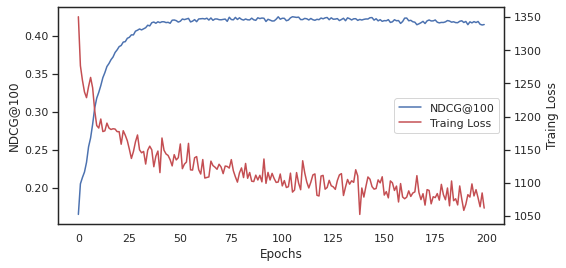

In [73]:
sn.set(style='white')
fig, ax = plt.subplots(figsize=(8,4))
twin1 = ax.twinx()
ndcg_line, = ax.plot(ndcgs_vad, "b-", label='NDCG@100')
loss_line, = twin1.plot(loss_log, "r-", label='Traing Loss')
ax.set_ylabel("NDCG@100")
twin1.set_ylabel("Traing Loss")
ax.set_xlabel("Epochs")
ax.legend(handles=[ndcg_line, loss_line], loc=7)
plt.savefig('../plots/VAE-training(holdout users).pdf', bbox_inches = 'tight')
plt.show()

### Test and Generate recommendation list

In [35]:
test_data_tr, test_data_te = load_tr_te_data(
    os.path.join(pro_dir, 'test_tr.csv'),
    os.path.join(pro_dir, 'test_te.csv'))

In [36]:
N_test = test_data_tr.shape[0]
idxlist_test = range(N_test)

batch_size_test = 2000

In [37]:
tf.reset_default_graph()
vae = MultiVAE(p_dims, lam=0.0)
saver, logits_var, _, _, _ = vae.build_graph()    

In [38]:
model_name = 'ml-1m-holdout-users'
chkpt_dir = os.path.join(model_save_path,'chkpt/{}/VAE_anneal{}K_cap{:1.1E}/{}_v2'.format(model_name,
    total_anneal_steps/1000, anneal_cap, arch_str))
print("chkpt directory: %s" % chkpt_dir)

chkpt directory: chkpt/ml-1m-holdout-users/VAE_anneal200.0K_cap2.0E-01/I-600-200-600-I_v2


In [39]:
n100_list, r20_list, r50_list = [], [], []
pred_all_test = np.empty(shape=(0,n_items))

with tf.Session() as sess:
    saver.restore(sess, '{}/model'.format(chkpt_dir))

    for bnum, st_idx in enumerate(range(0, N_test, batch_size_test)):
        end_idx = min(st_idx + batch_size_test, N_test)
        X = test_data_tr[idxlist_test[st_idx:end_idx]]

        if sparse.isspmatrix(X):
            X = X.toarray()
        X = X.astype('float32')

        pred_val = sess.run(logits_var, feed_dict={vae.input_ph: X})
        pred_all_test = np.concatenate((pred_all_test,pred_val),axis=0)
        # exclude examples from training and validation (if any)
        pred_val[X.nonzero()] = -np.inf
        n100_list.append(NDCG_binary_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=100))
        r20_list.append(Recall_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=20))
        r50_list.append(Recall_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=50))
    
n100_list = np.concatenate(n100_list)
r20_list = np.concatenate(r20_list)
r50_list = np.concatenate(r50_list)
print('Finish testing.')
print("Test NDCG@100=%.5f (%.5f)" % (np.mean(n100_list), np.std(n100_list) / np.sqrt(len(n100_list))))
print("Test Recall@20=%.5f (%.5f)" % (np.mean(r20_list), np.std(r20_list) / np.sqrt(len(r20_list))))
print("Test Recall@50=%.5f (%.5f)" % (np.mean(r50_list), np.std(r50_list) / np.sqrt(len(r50_list))))

Finish testing.
Test NDCG@100=0.42989 (0.00441)
Test Recall@20=0.35892 (0.00526)
Test Recall@50=0.45418 (0.00531)


## Compute popularity bias measure metrics

In [40]:
sorted_movieId = pd.read_csv('../processed_data/sorted_movieId.csv',header=None,index_col=0)

In [41]:
unique_sid = pd.unique(test_plays['movieId'])

In [42]:
id2show = dict((i, sid) for (i, sid) in enumerate(unique_sid)) 

In [43]:
def top_k_recList(predictions, id2show, k=10):
    n_users = predictions.shape[0]
    topk_movieId = []
    idx_topk_part = bn.argpartition(-predictions, k, axis=1)[:,:k].tolist()
    for i_pred in idx_topk_part:
        topk_movieId.append(list(map(lambda x: id2show[x], i_pred)))
    return topk_movieId

In [44]:
topk_all_test = top_k_recList(pred_all_test,id2show)
topk_all_test = pd.DataFrame(topk_all_test, columns = range(1,11))

In [45]:
ARP_at_10 = ARP(topk_all_test,sorted_movieId)
Agg_Div_at_10 = Agg_Div(topk_all_test,sorted_movieId)
print('ARP@10: {0:.4f}, Agg-Div@10: {1:.4f}'.format(ARP_at_10,Agg_Div_at_10))

ARP@10: 0.2005, Agg-Div@10: 0.3613


In [46]:
unique_uid = pd.unique(test_plays['userId'])
id2profile = dict((i, uid) for (i, uid) in enumerate(unique_uid)) 

In [47]:
# read the corresponding user group with their taste distribution
G1_user = pd.read_csv('../processed_data/group_data/G1_user.csv',header=0,index_col=0)
G2_user = pd.read_csv('../processed_data/group_data/G2_user.csv',header=0,index_col=0)
G3_user = pd.read_csv('../processed_data/group_data/G3_user.csv',header=0,index_col=0)

In [48]:
topk_all_test['userId'] = list(map(lambda x: id2profile[x], topk_all_test.index))

In [49]:
G1_topk = topk_all_test[topk_all_test['userId'].isin(G1_user.index)]
G2_topk = topk_all_test[topk_all_test['userId'].isin(G2_user.index)]
G3_topk = topk_all_test[topk_all_test['userId'].isin(G3_user.index)]

In [50]:
for topk_rec in [G1_topk, G2_topk, G3_topk]:
    ARP_at_10 = ARP(topk_rec[range(1,11)],sorted_movieId)
    Agg_Div_at_10 = Agg_Div(topk_rec[range(1,11)],sorted_movieId)
    print('ARP@10: {0:.4f}, Agg-Div@10: {1:.4f}'.format(ARP_at_10,Agg_Div_at_10))

ARP@10: 0.1921, Agg-Div@10: 0.1989
ARP@10: 0.2060, Agg-Div@10: 0.3060
ARP@10: 0.1913, Agg-Div@10: 0.1913


In [51]:
G1_topk.to_csv('predictions/G1_topk.csv',header=True, index=True)
G2_topk.to_csv('predictions/G2_topk.csv',header=True, index=True)
G3_topk.to_csv('predictions/G3_topk.csv',header=True, index=True)

The user taset of different group is manually computed using Excel. The idea of this computation is to find the probaility of each category of movies which presented in the recommendations list for users.

In [52]:
G1_user_taste = G1_user.loc[G1_topk['userId']].to_numpy()
G2_user_taste = G2_user.loc[G2_topk['userId']].to_numpy()
G3_user_taste = G3_user.loc[G3_topk['userId']].to_numpy()

In [53]:
G1_rec_taste = pd.read_csv('predictions/G1_rec_taste.csv',header=None).to_numpy()
G2_rec_taste = pd.read_csv('predictions/G2_rec_taste.csv',header=None).to_numpy()
G3_rec_taste = pd.read_csv('predictions/G3_rec_taste.csv',header=None).to_numpy()

In [55]:
print('G1 UDP:{0:.4f}'.format(group_UDP(G1_user_taste,G1_rec_taste)))
print('G2 UDP:{0:.4f}'.format(group_UDP(G2_user_taste,G2_rec_taste)))
print('G3 UDP:{0:.4f}'.format(group_UDP(G3_user_taste,G3_rec_taste)))

G1 UDP:0.1205
G2 UDP:0.0591
G3 UDP:0.0550


# Transfer data format for long-tail GAN training.

In [ ]:
train_plays.to_csv('../long-tail_GAN/Dataset/ml_1m_holdout_user/item_counts.csv',header=['userId','tagId','rating'], index=False)

In [44]:
test_plays[['userId','movieId','rating']].to_csv('../long-tail_GAN/Dataset/ml_1m_holdout_user/test_plays.csv',header=['userId','movieId','rating'], index=False)

In [ ]:
vad_data_tr.to_csv('../long-tail_GAN/Dataset/ml_1m_holdout_user/validation_tr.csv', index=False)
vad_data_te.to_csv('../long-tail_GAN/Dataset/ml_1m_holdout_user/validation_te.csv', index=False)
test_data_tr.to_csv('../long-tail_GAN/Dataset/ml_1m_holdout_user/test_tr.csv', index=False)
test_data_te.to_csv('../long-tail_GAN/Dataset/ml_1m_holdout_user/test_te.csv', index=False)

In [ ]:
unique_sid = pd.unique(raw_data['movieId'])
unique_uid = user_activity.index

In [ ]:
with open('../long-tail_GAN/Dataset/ml_1m_holdout_user/item_list.txt', 'w') as f:
    for sid in unique_sid:
        f.write('%s\n' % sid)

In [ ]:
with open('../long-tail_GAN/Dataset/ml_1m_holdout_user/unique_item_id.txt', 'w') as f:
    for (i, sid) in enumerate(unique_sid):
        f.write('%s\n' % i)

In [ ]:
with open('../long-tail_GAN/Dataset/ml_1m_holdout_user/item2id.txt', 'w') as f:
    for (i, sid) in enumerate(unique_sid):
        f.write('%s\t%s\n' % (sid,i))

In [ ]:
with open('../long-tail_GAN/Dataset/ml_1m/profile2id.txt', 'w') as f:
    for (i, uid) in enumerate(unique_uid):
        f.write('%s\t%s\n' % (uid,i))

In [ ]:
with open('../long-tail_GAN/Dataset/ml_1m_holdout_user/niche_items.txt', 'w') as f:
    for sid in pd.unique(raw_data[movies_pop == 2]['movieId']):
        f.write('%s\n' % sid)

In [ ]:
numerize(raw_data).to_csv('../long-tail_GAN/Dataset/ml_1m_holdout_user/train_GAN.csv', index=False)

In [ ]:
numerize(raw_data[movies_pop == 1]).to_csv('../long-tail_GAN/Dataset/ml_1m_holdout_user/train_GAN_popular.csv', index=False)

In [ ]:
numerize(raw_data[movies_pop == 2]).to_csv('../long-tail_GAN/Dataset/ml_1m_holdout_user/train_GAN_niche.csv', index=False)